# RAG Overview
> RAG(Retrieval-Augmented Generation): 대규모 언어 모델의 출력을 최적화하여 응답을 생성하기 전에 학습 데이터 소스 외부의 신뢰할 수 있는 지식 베이스를 참조하도록 하는 프로세스

## Why RAG?
- LLMs 는 개인/기업 데이터와 매우 최근의 데이터가 포함되지(학습되지) 않았다.
- LLM 은 각기 다른 context windows(Tokens) 가 있으며 모든 모델은 점점 더 커지고 있다. 즉 외부 소스의 정보를 점점 더 많이 넣을 수 있다는 것을 의미한다.

## RAG Stages
- `Indexing`: 외부 문서의 색인화
- `Retrieval`: 질문과 관련된 문서를 검색
- `Generation`: 질문과 추출된 문서를 기반으로 생성
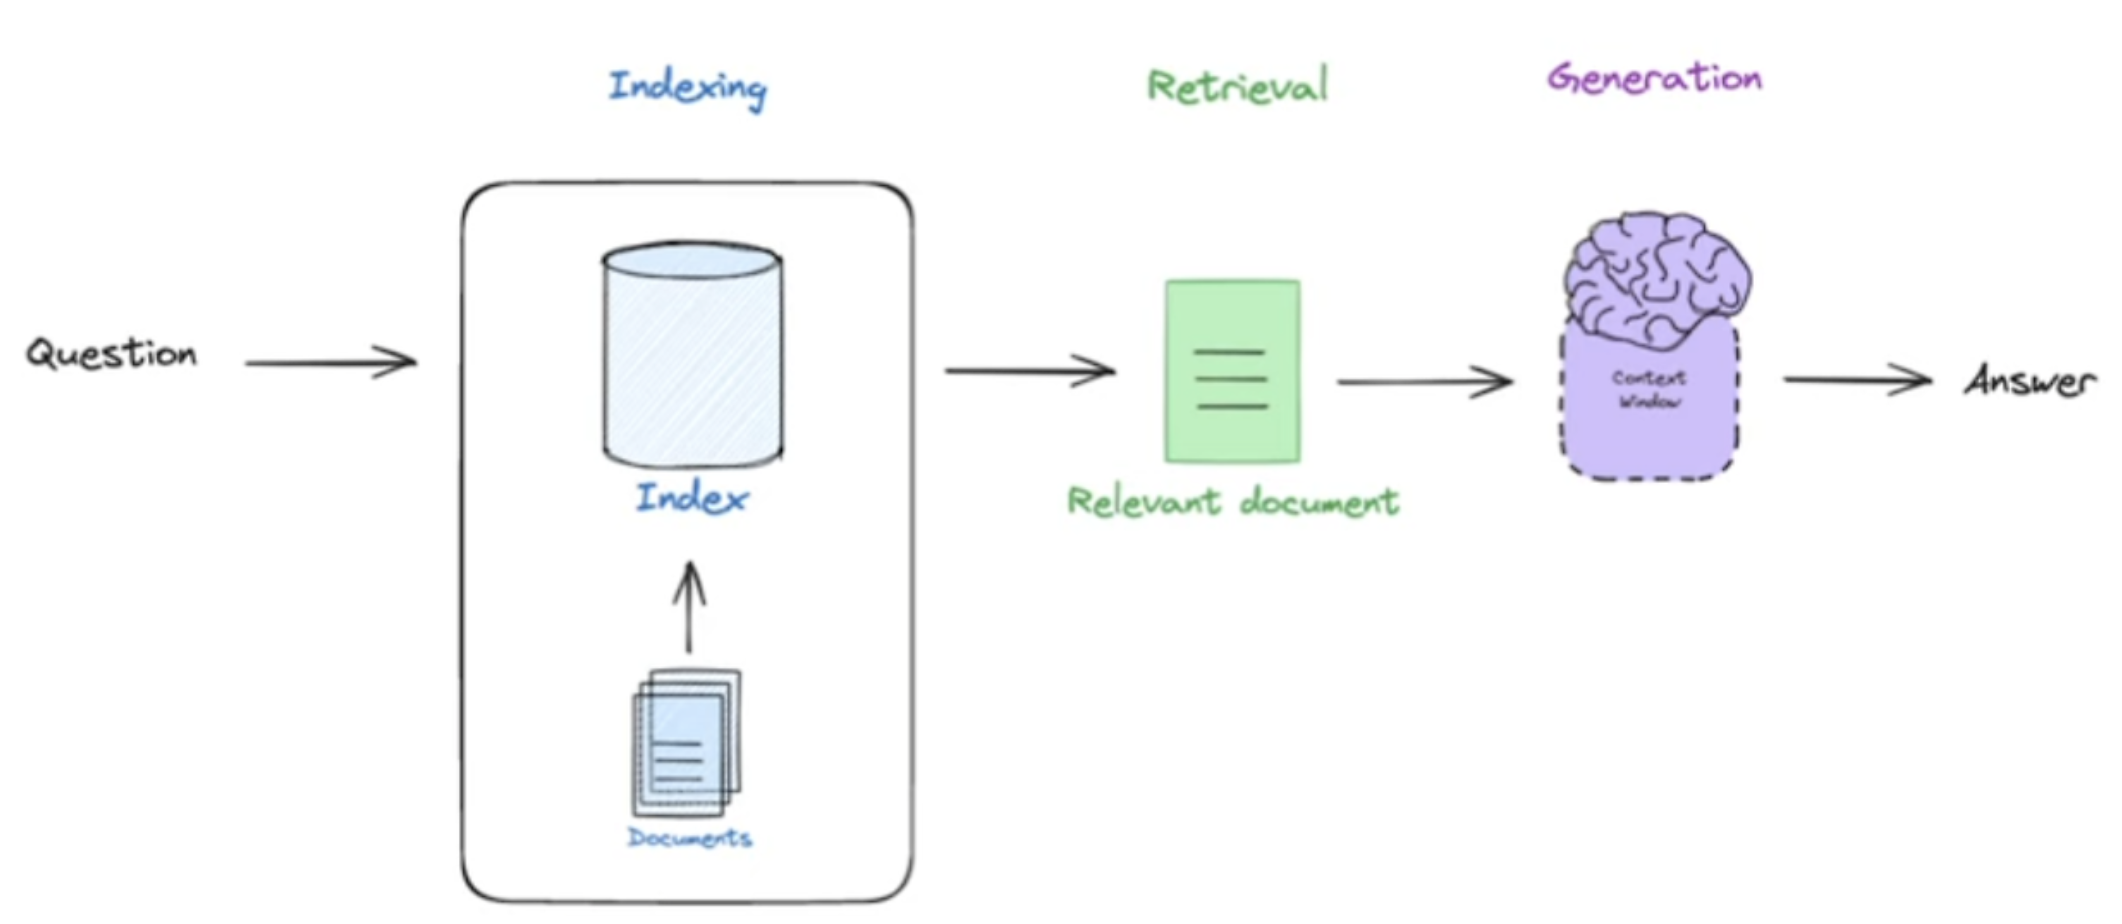

## Outline
1. Quick Start
2. Basic
    - Indexing 
    - Retrieval
    - Generation
3. Advanced
    - Query transformations
    - Routing
    - Query construction
    - Indexing
    - Retrieval
    - Generation

# 1. Quick Start

## Environment

### Packages

In [8]:
%%capture
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain python-dotenv bs4

### LangSmith & OpenAI API Key

In [6]:
from dotenv import load_dotenv
load_dotenv()

True

### Overview

In [9]:
import bs4
from langchain import hub # LangChain의 허브 모듈로, 다양한 AI 및 NLP 모델과 연결하는 데 사용
from langchain.text_splitter import RecursiveCharacterTextSplitter # 텍스트를 재귀적으로 분할하는 클래스 
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma # 벡터 스토어의 한 종류
from langchain_core.output_parsers import StrOutputParser # 문자열 출력을 파싱하는 데 사용되는 모듈
from langchain_core.runnables import RunnablePassthrough # 입력을 그대로 출력하는 단순한 실행 가능한 모듈
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

#### INDEXING ####

# Load Documents
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

# Embed
vectorstore = Chroma.from_documents(documents=splits, 
                                    embedding=OpenAIEmbeddings())
retriever = vectorstore.as_retriever()

#### RETRIEVAL and GENERATION ####

# Prompt
prompt = hub.pull("rlm/rag-prompt") # hub 에 저장된 해당 prompt template 를 가져오는 역할

# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)
    
# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# Question
rag_chain.invoke("What is Task Decomposition?")

USER_AGENT environment variable not set, consider setting it to identify your requests.


'Task Decomposition is a technique used to break down complex tasks into smaller and simpler steps. This approach allows agents to better plan and execute tasks efficiently. Task decomposition can be achieved through various methods such as prompting with specific instructions or utilizing human inputs.'

Output:

Task Decomposition is a technique used to break down complex tasks into smaller and simpler steps. This approach allows agents to better plan and execute tasks efficiently. Task decomposition can be achieved through various methods such as prompting with specific instructions or utilizing human inputs.

### LangSmith
#### Input & Output
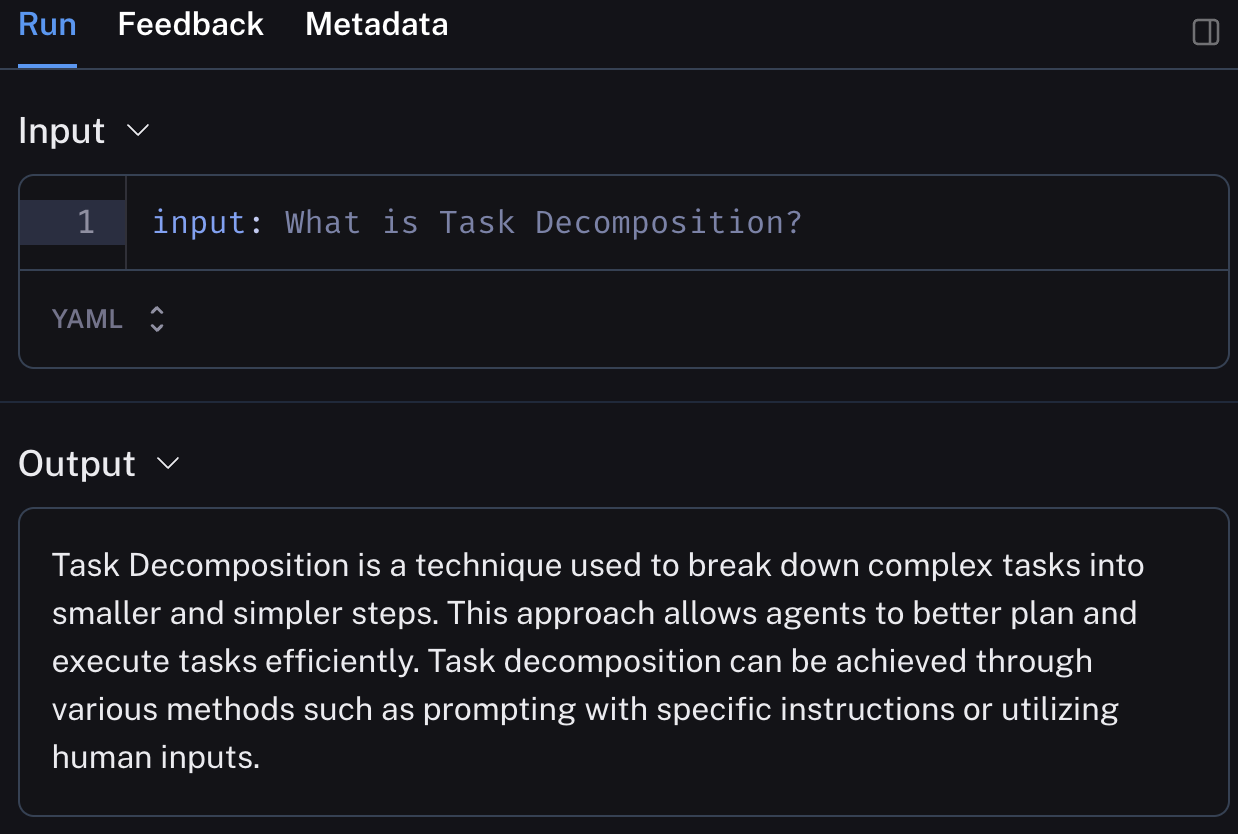

- Retrieval docs
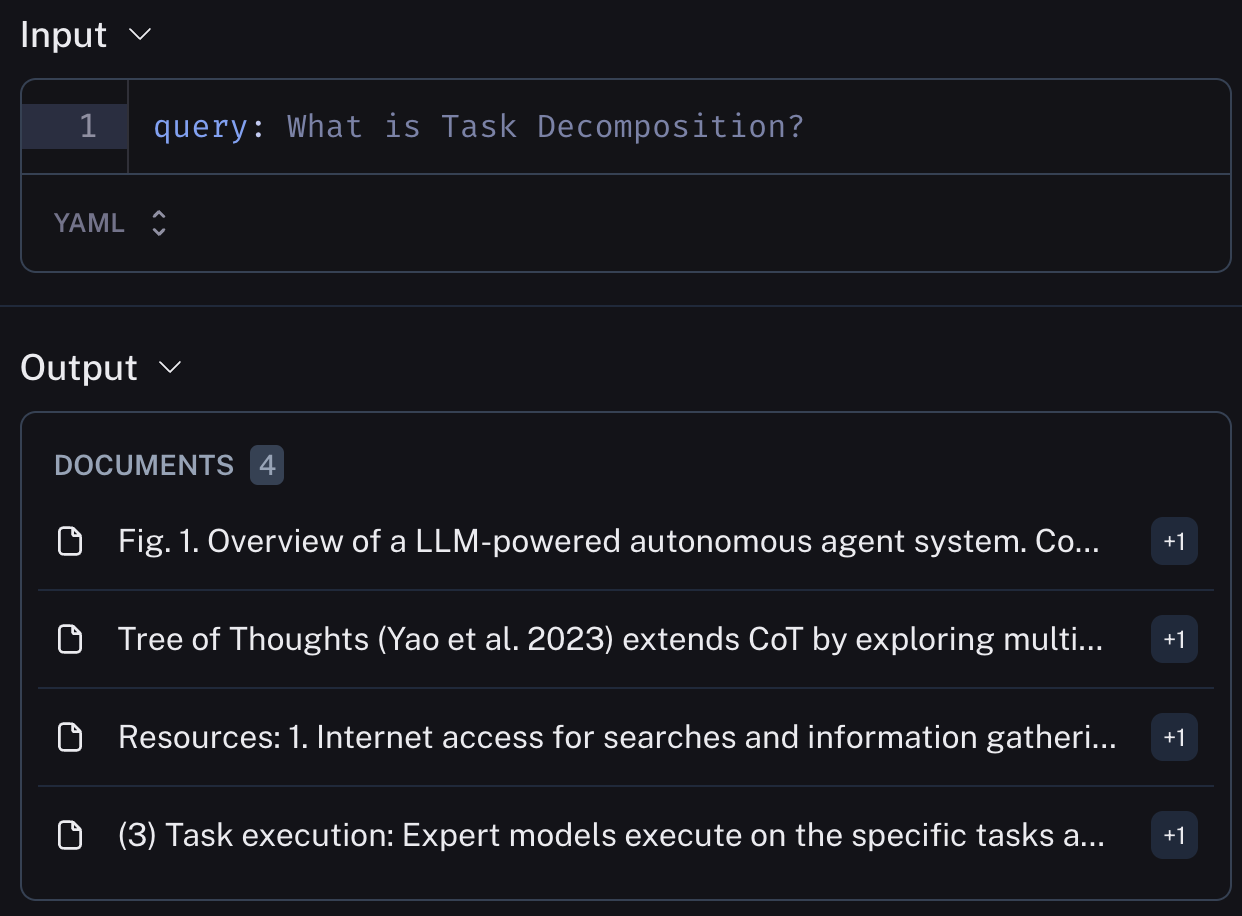